In [1]:
import pandas as pd

file_path = 'C:\\Users\\XUN\\Desktop\\project_myself\\MRegularSeasonDetailedResults.csv'
df = pd.read_csv(file_path)

# 筛选出第133天及以前的数据
df_filtered = df[df['DayNum'] <= 133]

# 显示筛选后的前几行数据
df_filtered.head()


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14


In [2]:
# Group the data by season
grouped_by_season = df_filtered.groupby('Season')

# This dictionary will store the grouped dataframes by season
grouped_dataframes = {season: group for season, group in grouped_by_season}

# Displaying the keys to confirm the grouping
list(grouped_dataframes.keys())


[2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020,
 2021,
 2022,
 2023,
 2024]

建立表格

In [3]:
# Create a new DataFrame for each year with unique team IDs
team_dataframes = {}

for season, group in grouped_dataframes.items():
    # Extract unique team IDs (both winners and losers)
    unique_teams = pd.concat([group['WTeamID'], group['LTeamID']]).unique()
    unique_teams.sort()  # Sorting the team IDs for readability
    # Create a new DataFrame with these team IDs
    team_df = pd.DataFrame(unique_teams, columns=['TeamID'])
    # Store this DataFrame in the dictionary
    team_dataframes[season] = team_df

# Display an example DataFrame for one season to check the structure
team_dataframes[2006].head()


,TeamID
0,1102
1,1103
2,1104
3,1105
4,1106


加入获胜率

In [4]:
# Iterate over each season's DataFrame to calculate win rates for each team
for season, group in grouped_dataframes.items():
    # Calculate win counts and loss counts for each team
    win_counts = group['WTeamID'].value_counts()
    loss_counts = group['LTeamID'].value_counts()
    
    # Initialize a list to store win rates
    win_rates = []
    
    # Calculate win rate for each team in the season
    for team_id in team_dataframes[season]['TeamID']:
        wins = win_counts.get(team_id, 0)
        losses = loss_counts.get(team_id, 0)
        total_games = wins + losses
        win_rate = wins / total_games if total_games > 0 else 0
        win_rates.append(win_rate)
    
    # Add the win rates as a new column to the DataFrame
    team_dataframes[season]['WinRate'] = win_rates

# Display an example DataFrame for one season to check the new column
team_dataframes[2004].head()


,TeamID,WinRate
0,1102,0.785714
1,1103,0.464286
2,1104,0.586207
3,1105,0.448276
4,1106,0.533333


计算后面13个指标（都取平均值）

In [5]:
# Define the columns that represent the game statistics we're interested in
# Assuming these are the detailed stats columns for both winning and losing teams
stats_columns = [
    'FGM', 'FGA', 'FGM3', 'FGA3', 'FTM', 'FTA', 'OR', 'DR', 'Ast', 'TO', 'Stl', 'Blk', 'PF'
]

# Iterate over each season to calculate average stats for each team
for season, group in grouped_dataframes.items():
    # Initialize a dictionary to store average stats for each team
    team_avg_stats = {team_id: {stat: 0 for stat in stats_columns} for team_id in team_dataframes[season]['TeamID']}
    
    # Calculate average stats for winning teams
    for stat in stats_columns:
        win_stats = group.groupby('WTeamID')[f'W{stat}'].mean()
        for team_id, avg in win_stats.items():
            if team_id in team_avg_stats:
                team_avg_stats[team_id][stat] = avg
                
    # Calculate average stats for losing teams, and combine with win stats for total average
    for stat in stats_columns:
        loss_stats = group.groupby('LTeamID')[f'L{stat}'].mean()
        for team_id, avg in loss_stats.items():
            if team_id in team_avg_stats:
                # Combine win and loss stats to get total average, weighted by number of games won/lost
                wins = group[group['WTeamID'] == team_id].shape[0]
                losses = group[group['LTeamID'] == team_id].shape[0]
                total_games = wins + losses
                if total_games > 0:  # Avoid division by zero
                    win_avg = team_avg_stats[team_id][stat] * (wins / total_games)
                    loss_avg = avg * (losses / total_games)
                    team_avg_stats[team_id][stat] = win_avg + loss_avg
    
    # Add the calculated averages to the DataFrame
    for stat in stats_columns:
        team_dataframes[season][stat] = team_dataframes[season]['TeamID'].apply(lambda id: team_avg_stats[id].get(stat, 0))





In [6]:
# Display an example DataFrame for one season to check the new columns
team_dataframes[2020].head()

,TeamID,WinRate,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF
0,1101,0.592593,24.592593,56.074074,6.481481,20.592593,17.111111,23.037037,10.037037,21.814815,13.592593,14.740741,9.000000,2.666667,22.000000
1,1102,0.354839,24.838710,55.096774,8.580645,23.225806,13.967742,19.290323,7.419355,24.741935,14.483871,12.451613,4.967742,1.225806,16.870968
2,1103,0.758621,24.965517,57.137931,9.172414,25.310345,15.620690,20.344828,9.517241,27.620690,12.655172,12.586207,4.896552,2.862069,17.931034
3,1104,0.516129,27.548387,63.096774,10.774194,30.870968,16.129032,23.258065,11.709677,27.645161,14.225806,14.903226,6.322581,4.387097,20.225806
4,1105,0.266667,21.866667,57.566667,5.133333,18.266667,12.633333,18.833333,9.633333,24.833333,10.866667,13.133333,5.800000,2.100000,17.933333


加入排名的文件

In [7]:
# Load the Excel file to check its structure
excel_file_path = 'C:\\Users\\XUN\\Desktop\\project_myself\\MMasseyOrdinals.csv'
excel_df = pd.read_csv(excel_file_path)

# Display the first few rows to understand its structure
excel_df.head()


,Season,RankingDayNum,SystemName,TeamID,OrdinalRank
0,2003,35,SEL,1102,159
1,2003,35,SEL,1103,229
2,2003,35,SEL,1104,12
3,2003,35,SEL,1105,314
4,2003,35,SEL,1106,260


In [8]:
# Filter out the first 10 days of ranking data for each season
filtered_rankings = excel_df[excel_df['RankingDayNum'] > 10]
# Initialize a dictionary to store the ranking statistics for each team and season
ranking_stats = {}

In [9]:
for season, group in filtered_rankings.groupby('Season'):
    team_stats = {}
    for team_id in team_dataframes[season]['TeamID']:
        team_ranks = group[group['TeamID'] == team_id]['OrdinalRank']
        if not team_ranks.empty:
            highest_rank = team_ranks.max()
            lowest_rank = team_ranks.min()
            median_rank = team_ranks.median()
            top_four_rank = team_ranks.quantile(0.25)  # Correctly representing the top 25%
            bottom_four_rank = team_ranks.quantile(0.75)  # Correctly representing the bottom 25%
            team_stats[team_id] = [highest_rank, top_four_rank, bottom_four_rank, median_rank, lowest_rank]

    # Fill the DataFrame with the calculated stats
    ranking_columns = ['HighestRank', 'TopFourRank', 'BottomFourRank', 'MedianRank', 'LowestRank']
    for index, row in team_dataframes[season].iterrows():
        team_id = row['TeamID']
        if team_id in team_stats:
            for i, stat in enumerate(ranking_columns):
                team_dataframes[season].at[index, stat] = team_stats[team_id][i]
        else:
            for stat in ranking_columns:
                team_dataframes[season].at[index, stat] = None  # Use None for teams without ranking data

# Display an example DataFrame for one season to check the corrections
team_dataframes[2003].head()


,TeamID,WinRate,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,HighestRank,TopFourRank,BottomFourRank,MedianRank,LowestRank
0,1102,0.428571,19.142857,39.785714,7.821429,20.821429,11.142857,17.107143,4.178571,16.821429,13.000000,11.428571,5.964286,1.785714,18.750000,219.0,130.00,160.00,149.0,52.0
1,1103,0.481481,27.148148,55.851852,5.444444,16.074074,19.037037,25.851852,9.777778,19.925926,15.222222,12.629630,7.259259,2.333333,19.851852,284.0,168.00,194.00,181.0,99.0
2,1104,0.607143,24.035714,57.178571,6.357143,19.857143,14.857143,20.928571,13.571429,23.928571,12.107143,13.285714,6.607143,3.785714,18.035714,106.0,18.00,34.75,30.0,1.0
3,1105,0.269231,24.384615,61.615385,7.576923,20.769231,15.423077,21.846154,13.500000,23.115385,14.538462,18.653846,9.307692,2.076923,20.230769,323.0,301.75,313.00,309.0,185.0
4,1106,0.464286,23.428571,55.285714,6.107143,17.642857,10.642857,16.464286,12.285714,23.857143,11.678571,17.035714,8.357143,3.142857,18.178571,307.0,229.00,261.25,245.0,166.0


In [10]:
team_dataframes[2005].head()

,TeamID,WinRate,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,HighestRank,TopFourRank,BottomFourRank,MedianRank,LowestRank
0,1102,0.586207,21.413793,47.724138,8.896552,24.413793,9.517241,13.068966,7.620690,15.413793,13.655172,10.068966,8.793103,1.724138,16.482759,198.0,69.75,103.0,88.0,9.0
1,1103,0.642857,24.785714,55.785714,8.142857,21.357143,13.892857,20.357143,10.285714,23.071429,16.107143,13.357143,6.750000,3.857143,18.821429,269.0,73.00,121.0,89.0,33.0
2,1104,0.766667,25.366667,52.666667,7.633333,19.566667,17.066667,23.266667,10.233333,26.466667,13.833333,12.666667,5.200000,4.433333,14.733333,86.0,15.00,23.0,18.0,7.0
3,1105,0.551724,23.655172,59.000000,6.103448,20.241379,15.655172,25.517241,12.931034,24.310345,13.137931,15.241379,10.620690,3.862069,19.344828,325.0,255.00,290.0,276.0,119.0
4,1106,0.500000,19.433333,51.000000,4.533333,15.100000,14.566667,22.433333,11.266667,22.400000,10.366667,15.766667,6.700000,2.000000,17.466667,322.0,241.75,287.0,265.0,91.0


In [11]:
# Extract the final rankings for day 133 for each team and season
final_rankings = filtered_rankings[filtered_rankings['RankingDayNum'] == 114]

# Initialize a dictionary to store the final ranking for each team by season
final_rank_by_season_team = {}

# Populate the dictionary
for season, season_df in final_rankings.groupby('Season'):
    final_rank_by_season_team[season] = dict(zip(season_df['TeamID'], season_df['OrdinalRank']))

# Add the final rankings to the team_dataframes
for season, season_df in team_dataframes.items():
    if season in final_rank_by_season_team:
        season_df['FinalRankDay133'] = season_df['TeamID'].apply(lambda x: final_rank_by_season_team[season].get(x, None))
    else:
        season_df['FinalRankDay133'] = None  # For seasons without final ranking data

# Display an example DataFrame for one season to check the new column
team_dataframes[2003].head()


,TeamID,WinRate,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,...,TO,Stl,Blk,PF,HighestRank,TopFourRank,BottomFourRank,MedianRank,LowestRank,FinalRankDay133
0,1102,0.428571,19.142857,39.785714,7.821429,20.821429,11.142857,17.107143,4.178571,16.821429,...,11.428571,5.964286,1.785714,18.750000,219.0,130.00,160.00,149.0,52.0,161
1,1103,0.481481,27.148148,55.851852,5.444444,16.074074,19.037037,25.851852,9.777778,19.925926,...,12.629630,7.259259,2.333333,19.851852,284.0,168.00,194.00,181.0,99.0,210
2,1104,0.607143,24.035714,57.178571,6.357143,19.857143,14.857143,20.928571,13.571429,23.928571,...,13.285714,6.607143,3.785714,18.035714,106.0,18.00,34.75,30.0,1.0,33
3,1105,0.269231,24.384615,61.615385,7.576923,20.769231,15.423077,21.846154,13.500000,23.115385,...,18.653846,9.307692,2.076923,20.230769,323.0,301.75,313.00,309.0,185.0,301
4,1106,0.464286,23.428571,55.285714,6.107143,17.642857,10.642857,16.464286,12.285714,23.857143,...,17.035714,8.357143,3.142857,18.178571,307.0,229.00,261.25,245.0,166.0,221


In [12]:
compact_results_file_path = 'C:\\Users\\XUN\\Desktop\\project_myself\\MNCAATourneyCompactResults.csv'
compact_results_df = pd.read_csv(compact_results_file_path)

# Filter the data to include only the seasons from 2003 onwards
compact_results_df_2003_onwards = compact_results_df[compact_results_df['Season'] >= 2003]

compact_results_df_2003_onwards.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
1136,2003,134,1421,92,1411,84,N,1
1137,2003,136,1112,80,1436,51,N,0
1138,2003,136,1113,84,1272,71,N,0
1139,2003,136,1141,79,1166,73,N,0
1140,2003,136,1143,76,1301,74,N,1


In [13]:
# Creating the newnewdata DataFrame based on the compact_results_df_2003_onwards data
# The DataFrame will include columns for team_1, team_2, and the match result where 1 indicates team_1 won, and 0 indicates team_2 won

# Initialize the new DataFrame
newnewdata = pd.DataFrame()

# Assign team_1 and team_2 based on winning and losing team IDs
newnewdata['team_1'] = compact_results_df_2003_onwards['WTeamID']
newnewdata['team_2'] = compact_results_df_2003_onwards['LTeamID']

# Determine the match result; since team_1 is always the winner in our setup, the result will always be 1
newnewdata['result'] = 1  # team_1 wins

newnewdata.head()


,team_1,team_2,result
1136,1421,1411,1
1137,1112,1436,1
1138,1113,1272,1
1139,1141,1166,1
1140,1143,1301,1


In [14]:
# Create a dictionary to hold a DataFrame for each season
newnewdata_by_season = {}

# Group the compact results data by season
for season, group in compact_results_df_2003_onwards.groupby('Season'):
    # Initialize the DataFrame for the season
    df_season = pd.DataFrame()
    
    # Assign team_1 and team_2
    df_season['team_1'] = group['WTeamID']
    df_season['team_2'] = group['LTeamID']
    
    # Since team_1 is always the winner in our setup, the result will always be 1 for this DataFrame
    df_season['result'] = 1  # team_1 wins
    
    # Store the DataFrame in the dictionary
    newnewdata_by_season[season] = df_season

In [15]:
print(newnewdata_by_season[2018])


      team_1  team_2  result
2117    1347    1254       1
2118    1382    1417       1
2119    1393    1113       1
2120    1411    1300       1
2121    1104    1439       1
...      ...     ...     ...
2179    1242    1181       1
2180    1437    1403       1
2181    1276    1260       1
2182    1437    1242       1
2183    1437    1276       1

[67 rows x 3 columns]


In [16]:
# Iterate over each season in newnewdata_by_season
for season, season_df in newnewdata_by_season.items():
    # Check if the season is in team_dataframes (it should be)
    if season in team_dataframes:
        team_info_df = team_dataframes[season]

        # For team_1, merge the team information from team_info_df based on team_1's ID
        season_df = season_df.merge(team_info_df, left_on='team_1', right_on='TeamID', how='left')
        # Rename the columns to indicate they are for team_1
        season_df.rename(columns=lambda x: x if x in ['team_1', 'team_2', 'result'] else f"team_1_{x}", inplace=True)
        
        # For team_2, repeat the process
        season_df = season_df.merge(team_info_df, left_on='team_2', right_on='TeamID', how='left')
        # Rename the columns to indicate they are for team_2
        season_df.rename(columns=lambda x: x if x in ['team_1', 'team_2', 'result', 'team_1_TeamID'] + [f"team_1_{col}" for col in team_info_df.columns if col != 'TeamID'] else f"team_2_{x}", inplace=True)
        
        # Drop the duplicate TeamID columns
        season_df.drop(['team_1_TeamID', 'team_2_TeamID'], axis=1, inplace=True)

        # Update the dictionary with the enhanced DataFrame
        newnewdata_by_season[season] = season_df





In [17]:
# Display an example enhanced DataFrame for one season to check the new columns
print(newnewdata_by_season[2018].head(5))

   team_1  team_2  result  team_1_WinRate  team_1_FGM  team_1_FGA  \
0    1347    1254       1        0.625000   23.281250   54.843750   
1    1382    1417       1        0.781250   26.375000   57.843750   
2    1393    1113       1        0.606061   22.757576   54.424242   
3    1411    1300       1        0.441176   25.823529   58.500000   
4    1104    1439       1        0.558824   25.294118   55.205882   

   team_1_FGM3  team_1_FGA3  team_1_FTM  team_1_FTA  ...  team_2_TO  \
0     7.656250    21.812500   12.718750   17.343750  ...  14.121212   
1     7.750000    19.468750   17.406250   23.093750  ...  11.843750   
2     5.848485    18.181818   16.181818   21.848485  ...  10.709677   
3     7.823529    21.529412   18.176471   25.294118  ...  14.161290   
4     6.382353    19.676471   15.382353   22.882353  ...  11.937500   

   team_2_Stl  team_2_Blk  team_2_PF  team_2_HighestRank  team_2_TopFourRank  \
0    5.575758    3.151515  19.636364               335.0               263.0  

In [18]:
print(newnewdata_by_season[2019])

    team_1  team_2  result  team_1_WinRate  team_1_FGM  team_1_FGA  \
0     1125    1396       1        0.833333   31.666667   63.733333   
1     1192    1341       1        0.580645   26.193548   55.225806   
2     1113    1385       1        0.687500   26.593750   59.468750   
3     1295    1300       1        0.516129   24.580645   54.709677   
4     1120    1308       1        0.735294   27.029412   60.441176   
..     ...     ...     ...             ...         ...         ...   
62    1120    1246       1        0.735294   27.029412   60.441176   
63    1277    1181       1        0.823529   27.764706   57.176471   
64    1403    1277       1        0.812500   26.156250   55.468750   
65    1438    1120       1        0.906250   25.625000   53.593750   
66    1438    1403       1        0.906250   25.625000   53.593750   

    team_1_FGM3  team_1_FGA3  team_1_FTM  team_1_FTA  ...  team_2_TO  \
0     10.366667    27.966667   13.166667   17.900000  ...  11.156250   
1      7.806452

In [19]:
for season, df in newnewdata_by_season.items():
    # Reorder columns to move 'result' to the end
    columns = [col for col in df.columns if col != 'result'] + ['result']
    newnewdata_by_season[season] = df[columns]

In [20]:
print(newnewdata_by_season[2018].columns)

Index(['team_1', 'team_2', 'team_1_WinRate', 'team_1_FGM', 'team_1_FGA',
       'team_1_FGM3', 'team_1_FGA3', 'team_1_FTM', 'team_1_FTA', 'team_1_OR',
       'team_1_DR', 'team_1_Ast', 'team_1_TO', 'team_1_Stl', 'team_1_Blk',
       'team_1_PF', 'team_1_HighestRank', 'team_1_TopFourRank',
       'team_1_BottomFourRank', 'team_1_MedianRank', 'team_1_LowestRank',
       'team_1_FinalRankDay133', 'team_2_WinRate', 'team_2_FGM', 'team_2_FGA',
       'team_2_FGM3', 'team_2_FGA3', 'team_2_FTM', 'team_2_FTA', 'team_2_OR',
       'team_2_DR', 'team_2_Ast', 'team_2_TO', 'team_2_Stl', 'team_2_Blk',
       'team_2_PF', 'team_2_HighestRank', 'team_2_TopFourRank',
       'team_2_BottomFourRank', 'team_2_MedianRank', 'team_2_LowestRank',
       'team_2_FinalRankDay133', 'result'],
      dtype='object')


In [21]:
import numpy as np

# Iterate over each season's DataFrame to randomly swap teams for 50% of the matches
for season, df in newnewdata_by_season.items():
    # Generate a random mask for selecting rows to swap
    swap_mask = np.random.rand(len(df)) < 0.5
    
    # Columns related to team_1 and team_2 that need to be swapped
    team_1_cols = [col for col in df.columns if 'team_1' in col]
    team_2_cols = [col for col in df.columns if 'team_2' in col]
    
    # Swap the team_1 and team_2 columns for rows identified by the mask
    df.loc[swap_mask, team_1_cols + team_2_cols] = df.loc[swap_mask, team_2_cols + team_1_cols].values
    
    # Update the result column for swapped rows: 1 becomes 0 since team_2 wins
    df.loc[swap_mask, 'result'] = 0

In [22]:
# Display an example DataFrame to verify the changes
print(newnewdata_by_season)

{2003:     team_1  team_2  team_1_WinRate  team_1_FGM  team_1_FGA  team_1_FGM3  \
0   1421.0  1411.0        0.448276   24.379310   56.793103     6.482759   
1   1112.0  1436.0        0.892857   30.321429   65.714286     7.035714   
2   1113.0  1272.0        0.620690   27.206897   56.896552     4.000000   
3   1166.0  1141.0        0.878788   28.696970   57.454545     7.969697   
4   1143.0  1301.0        0.724138   27.344828   58.724138     6.413793   
..     ...     ...             ...         ...         ...          ...   
59  1393.0  1328.0        0.827586   29.241379   62.206897     5.241379   
60  1277.0  1400.0        0.612903   23.032258   51.096774     4.903226   
61  1242.0  1266.0        0.766667   30.233333   62.300000     4.800000   
62  1400.0  1393.0        0.785714   28.000000   62.428571     5.857143   
63  1242.0  1393.0        0.766667   30.233333   62.300000     4.800000   

    team_1_FGA3  team_1_FTM  team_1_FTA  team_1_OR  ...  team_2_Stl  \
0     18.000000   15.

In [23]:
seeds_df = pd.read_csv('C:\\Users\\XUN\\Desktop\\project_myself\\2024_tourney_seeds.csv')


选出2024年的数据

In [24]:
# Merging the 2024 teams information with the corresponding team statistics from team_dataframes[2024]
merged_df_2024 = seeds_df.merge(team_dataframes[2024], on='TeamID', how='left')

merged_df_2024

,Tournament,Seed,TeamID,WinRate,FGM,FGA,FGM3,FGA3,FTM,FTA,...,TO,Stl,Blk,PF,HighestRank,TopFourRank,BottomFourRank,MedianRank,LowestRank,FinalRankDay133
0,M,W01,1163,0.892857,28.857143,58.357143,8.714286,24.178571,14.857143,20.000000,...,9.357143,6.392857,5.321429,16.607143,47.0,3.0,8.0,5.0,1.0,3
1,M,W02,1235,0.785714,27.785714,59.392857,6.642857,18.750000,15.000000,21.642857,...,10.464286,10.535714,2.964286,16.607143,135.0,8.0,26.0,14.0,2.0,12
2,M,W03,1228,0.750000,29.500000,62.571429,8.607143,24.714286,16.928571,22.857143,...,10.392857,4.464286,3.821429,15.214286,78.0,11.0,21.0,15.0,3.0,10
3,M,W04,1120,0.750000,28.500000,60.821429,8.000000,23.321429,17.750000,23.500000,...,10.214286,7.571429,5.785714,18.821429,106.0,7.0,19.0,11.0,2.0,6
4,M,W05,1361,0.740741,25.851852,57.407407,6.888889,21.592593,16.148148,22.000000,...,10.518519,7.370370,3.851852,17.407407,86.0,19.0,31.0,24.0,2.0,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,M,Z12,1241,0.896552,29.689655,62.896552,8.482759,23.758621,15.137931,21.379310,...,10.241379,8.965517,2.862069,17.689655,167.0,39.0,71.0,58.0,5.0,57
60,M,Z13,1436,0.777778,25.444444,56.740741,8.444444,25.370370,11.481481,15.777778,...,8.333333,5.222222,3.814815,13.814815,339.0,97.0,123.0,112.0,46.0,94
61,M,Z14,1324,0.633333,27.066667,60.233333,8.633333,24.666667,13.600000,18.100000,...,11.033333,6.633333,2.333333,15.000000,260.0,116.0,146.0,130.0,68.0,121
62,M,Z15,1443,0.640000,28.680000,61.960000,6.600000,19.320000,14.400000,20.200000,...,13.560000,7.040000,3.040000,18.840000,359.0,133.0,166.0,148.0,70.0,145


In [25]:
M_merge = merged_df_2024[merged_df_2024['Tournament'].str.contains('M')]
W_merge = merged_df_2024[merged_df_2024['Tournament'].str.contains('W')]

In [26]:
M_merge

,Tournament,Seed,TeamID,WinRate,FGM,FGA,FGM3,FGA3,FTM,FTA,...,TO,Stl,Blk,PF,HighestRank,TopFourRank,BottomFourRank,MedianRank,LowestRank,FinalRankDay133
0,M,W01,1163,0.892857,28.857143,58.357143,8.714286,24.178571,14.857143,20.000000,...,9.357143,6.392857,5.321429,16.607143,47.0,3.0,8.0,5.0,1.0,3
1,M,W02,1235,0.785714,27.785714,59.392857,6.642857,18.750000,15.000000,21.642857,...,10.464286,10.535714,2.964286,16.607143,135.0,8.0,26.0,14.0,2.0,12
2,M,W03,1228,0.750000,29.500000,62.571429,8.607143,24.714286,16.928571,22.857143,...,10.392857,4.464286,3.821429,15.214286,78.0,11.0,21.0,15.0,3.0,10
3,M,W04,1120,0.750000,28.500000,60.821429,8.000000,23.321429,17.750000,23.500000,...,10.214286,7.571429,5.785714,18.821429,106.0,7.0,19.0,11.0,2.0,6
4,M,W05,1361,0.740741,25.851852,57.407407,6.888889,21.592593,16.148148,22.000000,...,10.518519,7.370370,3.851852,17.407407,86.0,19.0,31.0,24.0,2.0,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,M,Z12,1241,0.896552,29.689655,62.896552,8.482759,23.758621,15.137931,21.379310,...,10.241379,8.965517,2.862069,17.689655,167.0,39.0,71.0,58.0,5.0,57
60,M,Z13,1436,0.777778,25.444444,56.740741,8.444444,25.370370,11.481481,15.777778,...,8.333333,5.222222,3.814815,13.814815,339.0,97.0,123.0,112.0,46.0,94
61,M,Z14,1324,0.633333,27.066667,60.233333,8.633333,24.666667,13.600000,18.100000,...,11.033333,6.633333,2.333333,15.000000,260.0,116.0,146.0,130.0,68.0,121
62,M,Z15,1443,0.640000,28.680000,61.960000,6.600000,19.320000,14.400000,20.200000,...,13.560000,7.040000,3.040000,18.840000,359.0,133.0,166.0,148.0,70.0,145


In [27]:
import pandas as pd
from itertools import combinations

# 假设M_merge是已经定义并包含合并数据的DataFrame
# Create all unique pairs of seeds without repeating pairs (team against itself)
seed_pairs = list(combinations(M_merge['Seed'].unique(), 2))

# Initialize an empty DataFrame for the new matrix
columns = ['team_1', 'team_2'] + [f'team_1_{col}' for col in M_merge.columns if col not in ['Tournament', 'Seed', 'TeamID']] + [f'team_2_{col}' for col in M_merge.columns if col not in ['Tournament', 'Seed', 'TeamID']]
team_pro = pd.DataFrame(columns=columns)

# Populate the new matrix with the team stats for each pair
for seed1, seed2 in seed_pairs:
    team1_data = M_merge[M_merge['Seed'] == seed1].drop(columns=['Tournament', 'Seed', 'TeamID']).reset_index(drop=True)
    team2_data = M_merge[M_merge['Seed'] == seed2].drop(columns=['Tournament', 'Seed', 'TeamID']).reset_index(drop=True)
    
    # Join the two team's data
    combined_data = pd.concat([team1_data, team2_data], axis=1)
    
    # Add the seeds at the beginning
    combined_data.insert(0, 'Team1_Seed', seed1)
    combined_data.insert(1, 'Team2_Seed', seed2)
    
    # Rename columns to reflect team1 and team2
    combined_data.columns = columns
    
    # Append to the main DataFrame
    team_pro = pd.concat([team_pro, combined_data], ignore_index=True)

# Now 2024_team_pro will have the desired structure without teams playing against themselves
print(team_pro.head())


  team_1 team_2  team_1_WinRate  team_1_FGM  team_1_FGA  team_1_FGM3  \
0    W01    W02        0.892857   28.857143   58.357143     8.714286   
1    W01    W03        0.892857   28.857143   58.357143     8.714286   
2    W01    W04        0.892857   28.857143   58.357143     8.714286   
3    W01    W05        0.892857   28.857143   58.357143     8.714286   
4    W01    W06        0.892857   28.857143   58.357143     8.714286   

   team_1_FGA3  team_1_FTM  team_1_FTA  team_1_OR  ...  team_2_TO  team_2_Stl  \
0    24.178571   14.857143        20.0  10.178571  ...  10.464286   10.535714   
1    24.178571   14.857143        20.0  10.178571  ...  10.392857    4.464286   
2    24.178571   14.857143        20.0  10.178571  ...  10.214286    7.571429   
3    24.178571   14.857143        20.0  10.178571  ...  10.518519    7.370370   
4    24.178571   14.857143        20.0  10.178571  ...  10.214286    6.321429   

   team_2_Blk  team_2_PF  team_2_HighestRank  team_2_TopFourRank  \
0    2.96428

In [28]:
team_pro.columns

Index(['team_1', 'team_2', 'team_1_WinRate', 'team_1_FGM', 'team_1_FGA',
       'team_1_FGM3', 'team_1_FGA3', 'team_1_FTM', 'team_1_FTA', 'team_1_OR',
       'team_1_DR', 'team_1_Ast', 'team_1_TO', 'team_1_Stl', 'team_1_Blk',
       'team_1_PF', 'team_1_HighestRank', 'team_1_TopFourRank',
       'team_1_BottomFourRank', 'team_1_MedianRank', 'team_1_LowestRank',
       'team_1_FinalRankDay133', 'team_2_WinRate', 'team_2_FGM', 'team_2_FGA',
       'team_2_FGM3', 'team_2_FGA3', 'team_2_FTM', 'team_2_FTA', 'team_2_OR',
       'team_2_DR', 'team_2_Ast', 'team_2_TO', 'team_2_Stl', 'team_2_Blk',
       'team_2_PF', 'team_2_HighestRank', 'team_2_TopFourRank',
       'team_2_BottomFourRank', 'team_2_MedianRank', 'team_2_LowestRank',
       'team_2_FinalRankDay133'],
      dtype='object')

In [29]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

# 假设 'team_dataframes' 是包含2003到2023年数据的字典，'team_pro' 是用于预测的DataFrame

# Step 1: 数据预处理

# 将所有DataFrame合并为一个
all_data = pd.concat(newnewdata_by_season.values(), ignore_index=True)
all_data = all_data.drop(['team_1', 'team_2'], axis=1)
# Separating features and target
X = all_data.drop('result', axis=1)
y = all_data['result']

# 数据标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 保证 'team_pro_renamed' 有相同的列顺序
team_pro_aligned = team_pro[X.columns.tolist()]


In [30]:
print(all_data)

      team_1_WinRate  team_1_FGM  team_1_FGA  team_1_FGM3  team_1_FGA3  \
0           0.448276   24.379310   56.793103     6.482759    18.000000   
1           0.892857   30.321429   65.714286     7.035714    20.071429   
2           0.620690   27.206897   56.896552     4.000000    12.586207   
3           0.878788   28.696970   57.454545     7.969697    20.484848   
4           0.724138   27.344828   58.724138     6.413793    17.034483   
...              ...         ...         ...          ...          ...   
1310        0.781250   28.968750   59.625000     7.593750    20.656250   
1311        0.636364   27.515152   58.878788     8.909091    24.757576   
1312        0.781250   28.968750   59.625000     7.593750    20.656250   
1313        0.812500   25.093750   56.843750     6.812500    19.812500   
1314        0.812500   25.093750   56.843750     6.812500    19.812500   

      team_1_FTM  team_1_FTA  team_1_OR  team_1_DR  team_1_Ast  ...  \
0      15.965517   20.931034  12.275862 

In [31]:
print(team_pro_aligned)

      team_1_WinRate  team_1_FGM  team_1_FGA  team_1_FGM3  team_1_FGA3  \
0           0.892857   28.857143   58.357143     8.714286    24.178571   
1           0.892857   28.857143   58.357143     8.714286    24.178571   
2           0.892857   28.857143   58.357143     8.714286    24.178571   
3           0.892857   28.857143   58.357143     8.714286    24.178571   
4           0.892857   28.857143   58.357143     8.714286    24.178571   
...              ...         ...         ...          ...          ...   
2011        0.777778   25.444444   56.740741     8.444444    25.370370   
2012        0.777778   25.444444   56.740741     8.444444    25.370370   
2013        0.633333   27.066667   60.233333     8.633333    24.666667   
2014        0.633333   27.066667   60.233333     8.633333    24.666667   
2015        0.640000   28.680000   61.960000     6.600000    19.320000   

      team_1_FTM  team_1_FTA  team_1_OR  team_1_DR  team_1_Ast  ...  \
0      14.857143   20.000000  10.178571 

In [32]:
from sklearn.model_selection import train_test_split

# 将数据集分成训练集和测试集
train_data, test_data = train_test_split(all_data, test_size=0.2, random_state=42)


In [33]:
# 提取训练集和测试集的特征和目标变量
X_train = train_data.drop(columns=['result'])
y_train = train_data['result']

X_test = test_data.drop(columns=['result'])
y_test = test_data['result']

# 这里你可能需要对特征进行归一化或标准化
# 你可以使用 sklearn.preprocessing 中的方法


In [34]:
print(X_train)

      team_1_WinRate  team_1_FGM  team_1_FGA  team_1_FGM3  team_1_FGA3  \
209         0.633333   25.033333   57.933333     6.300000    18.433333   
312         0.818182   26.606061   59.272727     7.666667    21.090909   
140         0.781250   25.937500   55.937500     6.031250    16.281250   
905         0.593750   23.937500   56.125000     8.750000    24.250000   
783         0.575758   24.303030   54.484848     6.393939    16.818182   
...              ...         ...         ...          ...          ...   
1095        0.852941   26.941176   58.970588     6.794118    18.882353   
1130        0.640000   27.080000   61.400000     8.120000    24.120000   
1294        0.906250   27.906250   59.593750     9.718750    26.093750   
860         0.781250   26.156250   54.875000     6.843750    18.718750   
1126        0.714286   27.678571   59.142857     6.392857    18.892857   

      team_1_FTM  team_1_FTA  team_1_OR  team_1_DR  team_1_Ast  ...  \
209    14.633333   22.066667  12.933333 

In [35]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.utils import to_categorical

# Simulated loading of your data (replace with actual data loading)
df = all_data
df_future = team_pro_aligned

# Assuming df and df_future are already loaded as per your setup

# Normalize features except 'result'
scaler = MinMaxScaler()
df_features = df.drop(columns=['result'])
df_scaled = scaler.fit_transform(df_features)
df_future_scaled = scaler.transform(df_future)

# Function to create sequences
def create_sequences(features, target, sequence_length):
    X, y = [], []
    for i in range(len(features) - sequence_length):
        seq = features[i:i + sequence_length]
        label = target[i + sequence_length]
        X.append(seq)
        y.append(label)
    return np.array(X), np.array(y)

# Assuming the target is the 'result' column
sequence_length = 5  # This is a hyperparameter you can tune
X, y = create_sequences(df_scaled, df['result'].values, sequence_length)

# Splitting dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Model definition
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(128),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Use 'softmax' if you have more than two classes and adjust the last layer accordingly
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model training
history = model.fit(X_train, y_train, epochs=200, batch_size=64, validation_split=0.1)

# Evaluation
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

# Preparing the future dataset for prediction
# Assuming you want to predict the 'result' for the 'team_pro_aligned' dataset
# Note: This might involve creating sequences with the last few entries of `df` and the start of `df_future`
# For simplicity, here's a basic approach:

# If `team_pro_aligned` does not include a 'result' column, use only feature transformation
X_future = [df_future_scaled[i:i + sequence_length] for i in range(len(df_future_scaled) - sequence_length + 1)]
X_future = np.array(X_future)

# Making predictions
predictions = model.predict(X_future)


c:\Users\XUN\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.4824 - loss: 0.6952 - val_accuracy: 0.4915 - val_loss: 0.6993
Epoch 2/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5033 - loss: 0.6947 - val_accuracy: 0.4661 - val_loss: 0.6938
Epoch 3/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4916 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6947
Epoch 4/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4914 - loss: 0.6938 - val_accuracy: 0.4915 - val_loss: 0.6965
Epoch 5/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5047 - loss: 0.6919 - val_accuracy: 0.4407 - val_loss: 0.6951
Epoch 6/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5025 - loss: 0.6923 - val_accuracy: 0.4915 - val_loss: 0.6973
Epoch 7/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5300 - loss: 0.6919 - val_accuracy: 0.4831 - val_loss: 0.7005
Epoch 8/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4958 - loss: 0.6913 - val_accuracy: 0.

In [36]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split, GridSearchCV

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.2s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.5s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.5s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.5s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=300; total time=   1.1s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=300; total time=   1.5s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=300; total time=   1.2s
[CV] END colsample_bytree=0.3

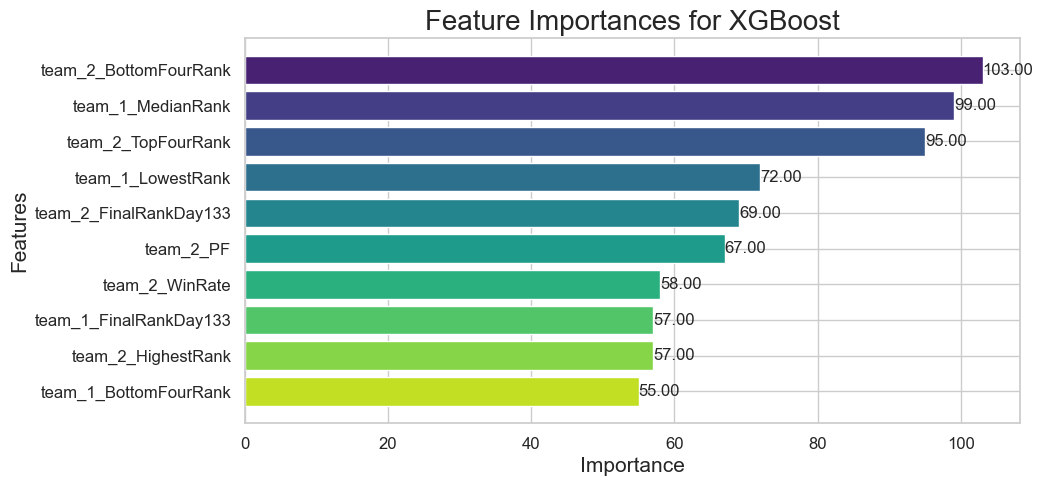

In [37]:
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

X = all_data.iloc[:, :-1]  # All rows, all columns except the last one
y = all_data.iloc[:, -1]   # All rows, just the last column
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def find_best_parameters(X_train, y_train):
    """
    Finds the best parameters for the XGBoost model using GridSearchCV.
    
    Parameters:
    - X_train: Training features.
    - y_train: Training target.
    
    Returns:
    - A trained XGBoost model with the best parameters found.
    """
    model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 4, 5],
        'colsample_bytree': [0.3, 0.7]
    }
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=3, verbose=2)
    grid_search.fit(X_train, y_train)
    print("Best parameters found: ", grid_search.best_params_)
    print("Best accuracy found: ", grid_search.best_score_)
    return grid_search.best_estimator_

def plot_feature_importances(model, max_num_features=None, color_scheme='viridis'):
    """
    Plot sorted feature importances for a trained XGBoost model.
    """
    sns.set(style="whitegrid")
    feature_importances = model.get_booster().get_score(importance_type='weight')
    sorted_features = sorted(feature_importances.items(), key=lambda kv: kv[1], reverse=True)
    
    if max_num_features:
        sorted_features = sorted_features[:max_num_features]
    
    sorted_features_names = [x[0] for x in sorted_features]
    sorted_features_values = [x[1] for x in sorted_features]
    
    plt.figure(figsize=(10, 8 if max_num_features is None else 0.5 * max_num_features)) 
    bars = plt.barh(sorted_features_names, sorted_features_values, color=sns.color_palette(color_scheme, len(sorted_features_names))) 
    for bar in bars:
        plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}', va='center', ha='left', fontsize=12)
    
    plt.xlabel('Importance', fontsize=15)
    plt.ylabel('Features', fontsize=15)
    plt.title('Feature Importances for XGBoost', fontsize=20)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.gca().invert_yaxis()
    plt.show()

# Find the best parameters and train the model
best_model = find_best_parameters(X_train, y_train)

# Plot the feature importances of the best model
plot_feature_importances(best_model, max_num_features=10, color_scheme='viridis')


In [38]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

# 初始化随机森林回归器，这里使用了更多的示例参数以提高预测准确度
rf_reg = RandomForestRegressor(
    n_estimators=500,      # 增加树的数量以提高模型的稳定性和准确度
    max_depth=200,          # 增加树的深度可以捕捉更复杂的数据关系，但要注意过拟合
    min_samples_split=100,  # 增加分割所需的最小样本数可以提高模型的泛化能力
    min_samples_leaf=4,    # 设置叶子节点的最小样本数，防止模型过于复杂而过拟合
    max_features='sqrt',   # 每次分割考虑的特征数量，'sqrt'通常是一个不错的起点
    bootstrap=True,        # 使用样本的bootstrap抽样
    random_state=45        # 设置随机状态以确保结果的可重复性
)

# 训练模型
rf_reg.fit(X_train, y_train)

# 使用模型进行预测
predictions = rf_reg.predict(X_test)

# 计算RMSE
rmse = sqrt(mean_squared_error(y_test, predictions))
print("RMSE: %f" % (rmse))


RMSE: 0.432225


C:\Users\XUN\AppData\Local\Temp\ipykernel_23304\1510723465.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=features_sorted, x='Importance', y='Feature', palette='viridis', order=features_sorted['Feature'])


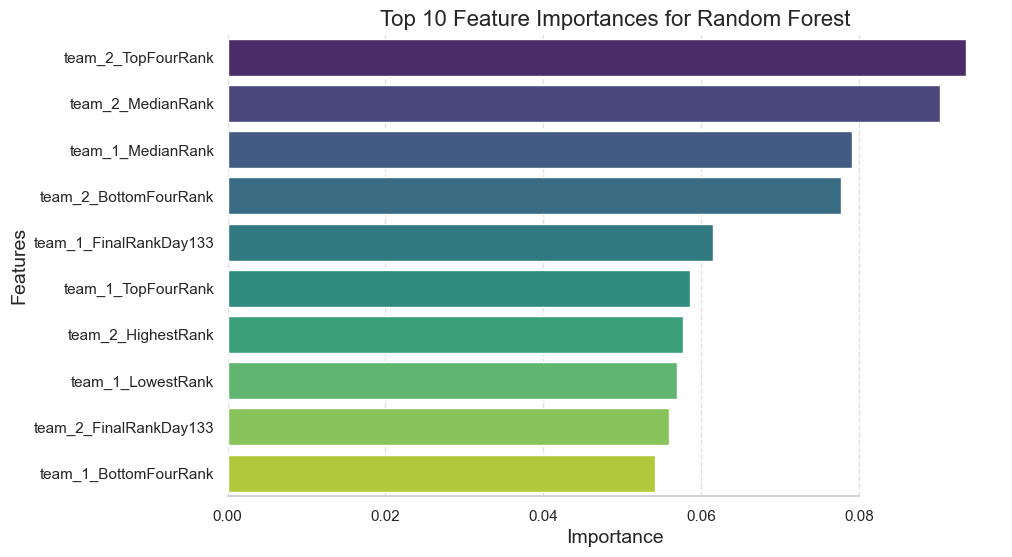

In [39]:
features_importance = rf_reg.feature_importances_
features_names = X.columns

features_df = pd.DataFrame({'Feature': features_names, 'Importance': features_importance})
features_sorted = features_df.sort_values(by='Importance', ascending=False).head(10)

# 使用 seaborn 画出一个更现代化的条形图
plt.figure(figsize=(10, 6))
sns.barplot(data=features_sorted, x='Importance', y='Feature', palette='viridis', order=features_sorted['Feature'])
plt.title('Top 10 Feature Importances for Random Forest', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.6)
sns.despine(trim=True, left=True)
plt.show()

In [40]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam



# 定义一个简单的神经网络模型进行二分类
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# 编译模型
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# 训练模型
history = model.fit(X_train, y_train, epochs=1000, batch_size=10, validation_split=0.2, verbose=1)

# 评估模型
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')


Epoch 1/1000


c:\Users\XUN\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6337 - loss: 2.3835 - val_accuracy: 0.6588 - val_loss: 1.0596
Epoch 2/1000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6384 - loss: 0.9616 - val_accuracy: 0.5355 - val_loss: 1.3505
Epoch 3/1000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6218 - loss: 0.8204 - val_accuracy: 0.6635 - val_loss: 0.8647
Epoch 4/1000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6470 - loss: 0.8008 - val_accuracy: 0.6825 - val_loss: 0.6630
Epoch 5/1000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6840 - loss: 0.6387 - val_accuracy: 0.6635 - val_loss: 0.8437
Epoch 6/1000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7091 - loss: 0.7494 - val_accuracy: 0.6635 - val_loss: 0.6896
Epoch 7/1000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6811 - loss: 0.6086 - val_accuracy: 0.6398 - val_loss: 0.6660
Epoch 8/1000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7150 - loss: 0.6128 - val_accuracy: 0.6445 - val_lo

<Figure size 1000x600 with 0 Axes>

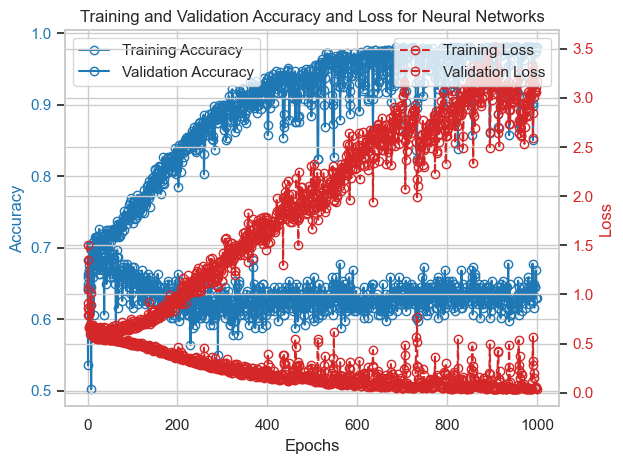

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# 设定Seaborn的样式
sns.set(style='whitegrid')
# 设置图表大小
plt.figure(figsize=(10, 6))
# Adjusting the plot based on user feedback
# Now making the markers hollow and continuing the code from where it left

# Set the figure size to match the user's plot

# Create a plot object and the first y-axis
fig, ax1 = plt.subplots()

# Set the first y-axis label and color
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy', color='tab:blue')
ax1.plot(history.history['accuracy'], label='Training Accuracy', marker='o', fillstyle='none', color='tab:blue')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o', fillstyle='none', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc='upper left')

# Create the second y-axis sharing the same x-axis
ax2 = ax1.twinx()  

# Set the second y-axis label and color
ax2.set_ylabel('Loss', color='tab:red')  
ax2.plot(history.history['loss'], label='Training Loss', marker='o', linestyle='--', fillstyle='none', color='tab:red')
ax2.plot(history.history['val_loss'], label='Validation Loss', marker='o', linestyle='--', fillstyle='none', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.legend(loc='upper right')

# Show the title and plot
plt.title('Training and Validation Accuracy and Loss for Neural Networks')
plt.tight_layout()
plt.show()


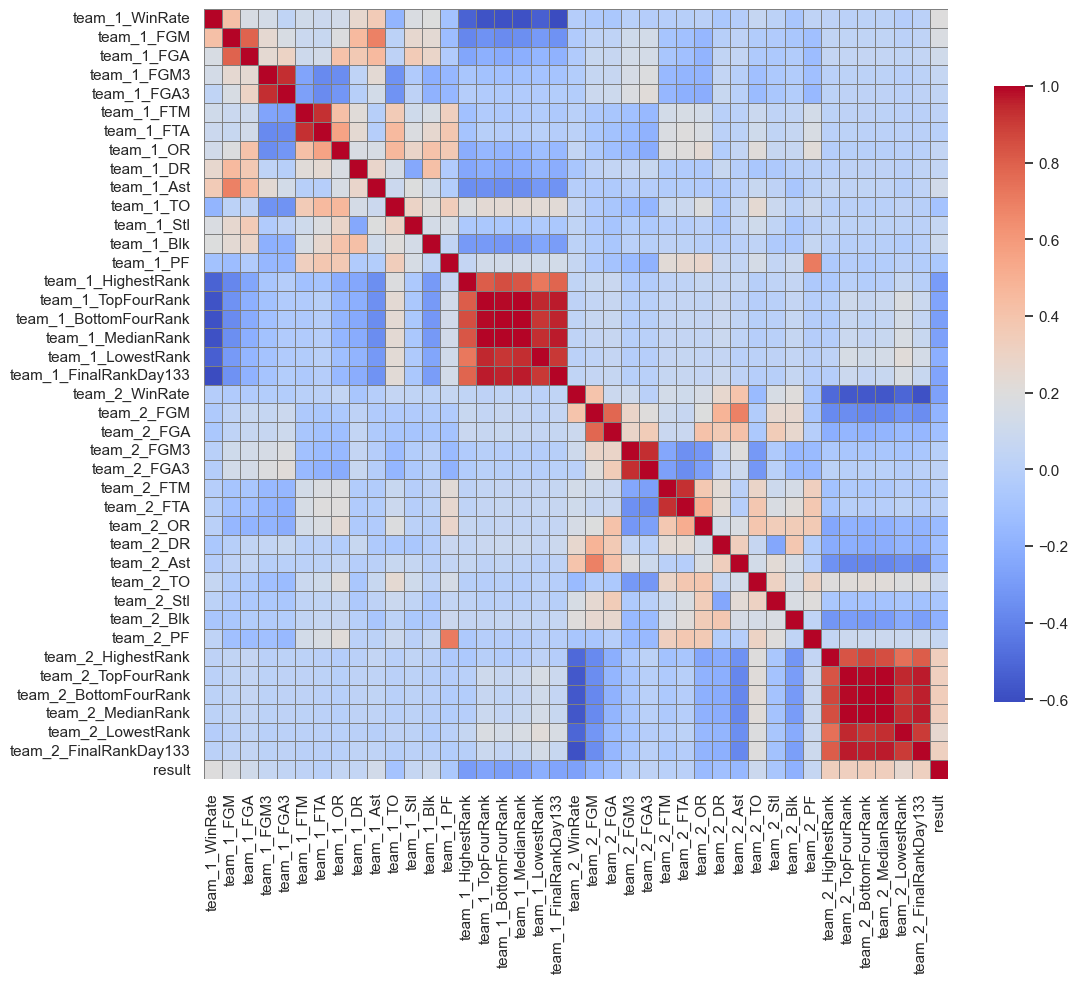

In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 计算相关性矩阵
correlation_matrix = all_data.corr()

# 使用 seaborn 绘制热力图
plt.figure(figsize=(12, 10))  # 调整图像大小
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm',
            linewidths=0.5, linecolor='gray',  # 增加网格线以提高可读性
            cbar_kws={"shrink": .8})  # 调整颜色条大小

# 隐藏坐标轴的标签
plt.xticks()
plt.yticks()
plt.show()


In [43]:
all_data.columns

Index(['team_1_WinRate', 'team_1_FGM', 'team_1_FGA', 'team_1_FGM3',
       'team_1_FGA3', 'team_1_FTM', 'team_1_FTA', 'team_1_OR', 'team_1_DR',
       'team_1_Ast', 'team_1_TO', 'team_1_Stl', 'team_1_Blk', 'team_1_PF',
       'team_1_HighestRank', 'team_1_TopFourRank', 'team_1_BottomFourRank',
       'team_1_MedianRank', 'team_1_LowestRank', 'team_1_FinalRankDay133',
       'team_2_WinRate', 'team_2_FGM', 'team_2_FGA', 'team_2_FGM3',
       'team_2_FGA3', 'team_2_FTM', 'team_2_FTA', 'team_2_OR', 'team_2_DR',
       'team_2_Ast', 'team_2_TO', 'team_2_Stl', 'team_2_Blk', 'team_2_PF',
       'team_2_HighestRank', 'team_2_TopFourRank', 'team_2_BottomFourRank',
       'team_2_MedianRank', 'team_2_LowestRank', 'team_2_FinalRankDay133',
       'result'],
      dtype='object')